# Dependencies

In [1]:
%%capture
!pip install pandas
!pip install pyarrow
!pip install tensorflow
!pip install protobuf==3.20.*
!pip install mediapipe==0.9.0.1

In [2]:
import os
import json
import shutil
import random
import matplotlib
import numpy as np
from itertools import chain
from collections import deque
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib import animation, rc
from IPython.display import display, Image

import cv2
import pandas as pd
import mediapipe as mp
import tensorflow as tf
from tensorflow import keras
import pyarrow.parquet as pq
from tensorflow.keras import layers
from mediapipe.framework.formats import landmark_pb2

In [3]:
!python --version
print("TensorFlow v" + tf.__version__)
print("Mediapipe v" + mp.__version__)

Python 3.9.13
TensorFlow v2.14.0
Mediapipe v0.9.0.1


In [4]:
random.seed(42)

# Load data

In [5]:
dataset_df = pd.read_csv('kaggle_dataset/train.csv')
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (94477, 4)


In [6]:
dataset_df.head()

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


In [7]:
def random_sequence():
    # Fetch sequence_id, file_id, phrase from first row
    path, sequence_id, sign = dataset_df.sample(n=1).iloc[0][['path', 'sequence_id', 'sign']]
    print(f"sequence_id: {sequence_id}, path: {path}, sign: {sign}")
    
    # Fetch data from parquet file (This dataset stores each landmark in a separate row)
    sample_sequence_df_wrong_format = pq.read_table(f"kaggle_dataset/{path}",).to_pandas()
    print("Full sequence dataset shape is {}".format(sample_sequence_df_wrong_format.shape))
    
    return sample_sequence_df_wrong_format

In [90]:
random_sequence()

sequence_id: 1920466207, path: train_landmark_files/32319/1920466207.parquet, sign: airplane
Full sequence dataset shape is (26064, 7)


,frame,row_id,type,landmark_index,x,y,z
0,18,18-face-0,face,0,0.471518,0.486392,-0.037979
1,18,18-face-1,face,1,0.470423,0.437123,-0.073338
2,18,18-face-2,face,2,0.469413,0.447945,-0.037587
3,18,18-face-3,face,3,0.456115,0.401791,-0.056927
4,18,18-face-4,face,4,0.470224,0.426398,-0.078442
...,...,...,...,...,...,...,...
26059,65,65-right_hand-16,right_hand,16,NaN,NaN,NaN
26060,65,65-right_hand-17,right_hand,17,NaN,NaN,NaN
26061,65,65-right_hand-18,right_hand,18,NaN,NaN,NaN
26062,65,65-right_hand-19,right_hand,19,NaN,NaN,NaN


In [32]:
# Check if all frames contain all coords
# for i, row in tqdm(dataset_df.iterrows()):
#     path, sequence_id, sign = row[['path', 'sequence_id', 'sign']].values
#     l = len(pq.read_table(f"kaggle_dataset/{path}",).to_pandas())
#     if l % 543 != 0:
#         print(l/543)

In [143]:
NUM_COORDS_FRAME = 543

def gen_column_names(prefix: str, name: str, count: int):
    col_names = []
    for i in range(0, count+1):
        col_names.append(f"{prefix}_{name}_{i}")
    return col_names

columns = list(chain(
    gen_column_names("x", "face", 467),
    gen_column_names("x", "left_hand", 20),
    gen_column_names("x", "pose", 32),
    gen_column_names("x", "right_hand", 20),
    gen_column_names("y", "face", 467),
    gen_column_names("y", "left_hand", 20),
    gen_column_names("y", "pose", 32),
    gen_column_names("y", "right_hand", 20),
    gen_column_names("z", "face", 467),
    gen_column_names("z", "left_hand", 20),
    gen_column_names("z", "pose", 32),
    gen_column_names("z", "right_hand", 20),
))

# Transform the dataframe to be tha same format as the fingerspelling dataset (1 row for each frame)
def transform_df(df):
    x = df.x
    y = df.y
    z = df.z

    num_frames = len(df) // NUM_COORDS_FRAME
    x = x.values.reshape(num_frames, NUM_COORDS_FRAME)
    y = y.values.reshape(num_frames, NUM_COORDS_FRAME)
    z = z.values.reshape(num_frames, NUM_COORDS_FRAME)

    data = np.concatenate((x, y, z), axis=1)
        
    return pd.DataFrame(data, columns=columns)

In [79]:
%%time
transform_df(random_sequence()).head()

sequence_id: 3837306777, path: train_landmark_files/49445/3837306777.parquet, sign: find
Full sequence dataset shape is (30951, 7)
CPU times: total: 46.9 ms
Wall time: 44.1 ms


,x_face_0,x_face_1,x_face_2,x_face_3,x_face_4,x_face_5,x_face_6,x_face_7,x_face_8,x_face_9,...,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20
0,0.458160,0.451398,0.456444,0.438777,0.449290,0.447877,0.445557,0.379159,0.442311,0.439941,...,-0.256722,-0.274762,-0.125358,-0.215154,-0.224347,-0.208409,-0.134969,-0.194373,-0.196333,-0.184045
1,0.462468,0.453417,0.457953,0.440656,0.451241,0.449630,0.446845,0.381374,0.443293,0.440885,...,-0.227497,-0.247128,-0.107957,-0.193193,-0.199321,-0.182043,-0.123788,-0.180968,-0.182438,-0.170139
2,0.455209,0.448173,0.453671,0.436749,0.446086,0.445122,0.444177,0.379897,0.441330,0.439130,...,-0.188491,-0.205645,-0.093357,-0.168795,-0.178496,-0.164908,-0.111747,-0.163900,-0.166492,-0.155050
3,0.455406,0.446035,0.451584,0.434724,0.443994,0.443079,0.442236,0.378136,0.439386,0.437185,...,-0.161937,-0.175065,-0.084418,-0.148335,-0.158028,-0.146746,-0.101686,-0.142224,-0.142941,-0.132157
4,0.451831,0.443711,0.449803,0.432760,0.441562,0.440717,0.440211,0.378443,0.437461,0.435151,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Animation preview

In [80]:
matplotlib.rcParams['animation.embed_limit'] = 2**128
matplotlib.rcParams['savefig.pad_inches'] = 0
rc('animation', html='jshtml')

def create_animation(images):
    fig = plt.figure(figsize=(6, 9))
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    im=ax.imshow(images[0], cmap="gray")
    plt.close(fig)
    
    def animate_func(i):
        im.set_array(images[i])
        return [im]

    return animation.FuncAnimation(fig, animate_func, frames=len(images), interval=1000/10)

mp_pose = mp.solutions.pose
mp_hands = mp.solutions.hands
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles

def collect_landmarks_oftype(_type: str, frame_data: pd.Series):
    x_type = frame_data.filter(regex=f"x_{_type}.*").values
    y_type = frame_data.filter(regex=f"y_{_type}.*").values
    z_type = frame_data.filter(regex=f"z_{_type}.*").values
    landmarks = landmark_pb2.NormalizedLandmarkList()
    for x, y, z in zip(x_type, y_type, z_type):
        landmarks.landmark.add(x=x, y=y, z=z)
    return landmarks
        
def produce_video_from_seq(seq_df: pd.DataFrame):
    frames = []
    for seq_idx in range(len(seq_df)):
        frame = np.zeros((600, 600, 3))
        frame_data = seq_df.iloc[seq_idx]
        
        # Right hand
        right_hand_landmarks = collect_landmarks_oftype("right_hand", frame_data)
        mp_drawing.draw_landmarks(
                frame,
                right_hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style())
        
        # Left Hand
        left_hand_landmarks = collect_landmarks_oftype("left_hand", frame_data)
        mp_drawing.draw_landmarks(
                frame,
                left_hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style())
        
        # Face
        face_landmarks = collect_landmarks_oftype("face", frame_data)
        mp_drawing.draw_landmarks(
            frame,
            face_landmarks,
            mp_holistic.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_contours_style())
        
        # Pose
        pose_landmarks = collect_landmarks_oftype("pose", frame_data)
        mp_drawing.draw_landmarks(
            frame,
            pose_landmarks,
            mp_holistic.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.
            get_default_pose_landmarks_style())
        
        frames.append(frame.astype(np.uint8))
    return frames

In [81]:
video = produce_video_from_seq(transform_df(random_sequence()))
create_animation(video)

sequence_id: 4156906371, path: train_landmark_files/55372/4156906371.parquet, sign: kitty
Full sequence dataset shape is (17376, 7)


# Statistics

In [82]:
def lengths_hist(lengths: list, title="", space=50):
    plt.hist(lengths, np.linspace(0, space, space))
    plt.ylim(plt.ylim())
    max_length = max(lengths)
    plt.plot([max_length, max_length], plt.ylim())
    plt.title(f'{title} (Max: {max_length})')
    plt.show()

def calc_percentiles(values: list, percentiles=[25, 50,75, 80, 90]):
    percentile_values = np.percentile(values, percentiles)
    for p, value in zip(percentiles, percentile_values):
        print(f"{p}th percentile: {value}")

## Statistics on the length of sequences:

This is an extremely long operation, and therefor only performed on a random subset of whole data.

In [124]:
seq_lengths = []

for file_path in tqdm(dataset_df.sample(n=3000).path):
    count = pq.read_table("kaggle_dataset/" + file_path, columns=['frame']).num_rows
    seq_lengths.append(count // NUM_COORDS_FRAME)

  0%|          | 0/3000 [00:00<?, ?it/s]

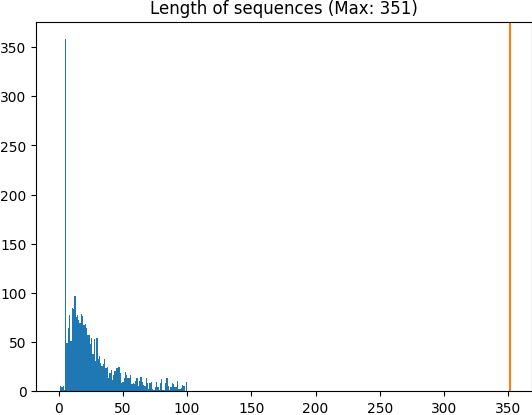

25th percentile: 12.0
50th percentile: 22.0
75th percentile: 44.0
80th percentile: 52.0
90th percentile: 92.0


In [125]:
lengths_hist(seq_lengths, "Length of sequences", 100)
calc_percentiles(seq_lengths)

For single signs Extremely long sequences are suspicious. It might be beneficial to cut those off from the training data.

# Save to TFRecords

In [226]:
# Pose coordinates for hand movement.
LPOSE = [13, 15, 17, 19, 21]
RPOSE = [14, 16, 18, 20, 22]
FPOSE = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
POSE = LPOSE + RPOSE + FPOSE

X = [f'x_right_hand_{i}' for i in range(21)] + [f'x_left_hand_{i}' for i in range(21)] + [f'x_pose_{i}' for i in POSE]
Y = [f'y_right_hand_{i}' for i in range(21)] + [f'y_left_hand_{i}' for i in range(21)] + [f'y_pose_{i}' for i in POSE]
Z = [f'z_right_hand_{i}' for i in range(21)] + [f'z_left_hand_{i}' for i in range(21)] + [f'z_pose_{i}' for i in POSE]

FEATURE_COLUMNS = X + Y + Z

X_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "x_" in col]
Y_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "y_" in col]
Z_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "z_" in col]

RHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "right" in col]
LHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "left" in col]
RPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col.split("_")[-1]) in RPOSE]
LPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col.split("_")[-1]) in LPOSE]
FPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col.split("_")[-1]) in FPOSE]

In [233]:
def save_tfrecords_to(folder: str):
    for part_id, group_df in tqdm(dataset_df.groupby(by="participant_id")):
        # Save each participant's data into separate files
        tf_file = f"{folder}/{part_id}.tfrecord"
        with tf.io.TFRecordWriter(tf_file) as file_writer:
            for file_path, sign in tqdm(zip(group_df.path, group_df.sign)):
                pq_file = pq.read_table(f"kaggle_dataset/{file_path}",columns=["x", "y", "z"])

                df_original_format = pq_file.to_pandas()
                formatted_df = transform_df(df_original_format)
                frames = formatted_df.values

                features = {formatted_df.columns[i]: tf.train.Feature(float_list=tf.train.FloatList(value=frames[:, i])) for i in range(len(formatted_df.columns))}
                features["phrase"] = tf.train.Feature(bytes_list=tf.train.BytesList(value=[bytes(sign, 'utf-8')]))
                record_bytes = tf.train.Example(features=tf.train.Features(feature=features)).SerializeToString()
                file_writer.write(record_bytes)

In [234]:
folder_name = "train_tfrecords_all_coords"
if not os.path.isdir(folder_name):
    os.mkdir(folder_name)
    save_tfrecords_to(folder_name)
else:
    print(f"Warning: Tfrecords already exist! Delete the {folder_name} folder to regenerate them!")

  0%|          | 0/21 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

# Fetch from TFRecords

In [179]:
tf_records = dataset_df.participant_id.map(lambda x: f'{folder_name}/{x}.tfrecord').unique()
print(f"List of {len(tf_records)} TFRecord files.")

List of 21 TFRecord files.


In [180]:
def decode_fn(record_bytes):
    schema = {COL: tf.io.VarLenFeature(dtype=tf.float32) for COL in FEATURE_COLUMNS}
    schema["phrase"] = tf.io.FixedLenFeature([], dtype=tf.string)
    features = tf.io.parse_single_example(record_bytes, schema)
    phrase = features["phrase"]
    landmarks = ([tf.sparse.to_dense(features[COL]) for COL in FEATURE_COLUMNS])
    # Transpose to maintain the original shape of landmarks data.
    landmarks = tf.transpose(landmarks)
    
    return landmarks, phrase

In [181]:
sorted_signs = sorted(set(dataset_df.sign))
sign_to_num = {sign : i for i, sign in enumerate(sorted_signs)}
num_to_sign = {i : sign for sign, i in sign_to_num.items()}

In [182]:
FRAME_LEN = 100

def preprocess_landmarks(x):
    # Pad end of sequence to be exactly FRAME_LEN long
    if tf.shape(x)[0] < FRAME_LEN:
        x = tf.pad(x, ([[0, FRAME_LEN-tf.shape(x)[0]], [0, 0]]))
    else:
        x = x[:FRAME_LEN, :]
        
    # Replace NaN values with 0
    x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
    
    return x

table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=list(sign_to_num.keys()),
        values=list(sign_to_num.values()),
    ),
    default_value=tf.constant(-1),
    name="signs"
)

def preprocess_phrase(phrase):
    return table.lookup(phrase)

def convert_fn(landmarks, phrase):
    return preprocess_landmarks(landmarks), preprocess_phrase(phrase)

In [183]:
batch_size = 64
shuffle_buffer_size = 4*batch_size
train_len = int(0.8 * len(tf_records))

train_ds = tf.data.TFRecordDataset(tf_records[:train_len]).map(decode_fn).map(convert_fn).shuffle(buffer_size=shuffle_buffer_size).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE).cache()
valid_ds = tf.data.TFRecordDataset(tf_records[train_len:]).map(decode_fn).map(convert_fn).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE).cache()

In [184]:
train_iterator = iter(train_ds)

print("Training Data:")
landmarks, phrase = next(train_iterator)
lm_shape = landmarks.shape[2]

print("Landmarks:")
print(type(landmarks))
print(landmarks.shape)
print(landmarks.numpy())
print("-" * 40)
print("Phrase:")
print(phrase.shape)
print(phrase)
print("-" * 40)

Training Data:
Landmarks:
<class 'tensorflow.python.framework.ops.EagerTensor'>
(64, 100, 186)
[[[ 0.41118893  0.4722687   0.53641903 ... -0.84024936 -1.178936
   -1.1838446 ]
  [ 0.39313084  0.4609949   0.52473086 ... -0.7524485  -1.1044416
   -1.1087312 ]
  [ 0.38680652  0.4520082   0.5149523  ... -0.8102673  -1.2408868
   -1.2407286 ]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]]

 [[ 0.25839087  0.31683654  0.34885004 ... -0.4825655  -0.9740424
   -0.9694913 ]
  [ 0.27129787  0.32800943  0.3581247  ... -0.5776947  -1.1408461
   -1.1410967 ]
  [ 0.2656801   0.32861075  0.36595568 ... -0.7965794  -1.3559012
   -1.3651668 ]
  ...
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.          0.         ...  0.          0.
    0.        ]
  [ 0.          0.       

# Transformer model

## Model creation

In [216]:
# https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/transformer.ipynb#scrollTo=1Rz82wEs5biZ

def positional_encoding(length, depth):
    depth = depth/2

    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)
    
    angle_rates = 1 / (10000**depths)         # (1, depth)
    angle_rads = positions * angle_rates      # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1) 

    return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalLandmarkEmbedding(tf.keras.layers.Layer):
    def __init__(self, len_of_seq, d_model, num_conv_layers, filter_size):
        super().__init__()
        self.d_model = d_model
        self.len_of_seq = len_of_seq
        # maybe add input for Convs
        self.conv_block = tf.keras.models.Sequential([
            tf.keras.layers.Conv1D(d_model, filter_size, padding="same", activation="relu")
            for _ in range(num_conv_layers)
        ])
        self.pos_encoding = positional_encoding(length=len_of_seq, depth=d_model)
        
    def call(self, x):
        #length = tf.shape(x)[1]
        x = self.conv_block(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :self.len_of_seq, :]
        return x
    
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()
    
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x
    
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),
          tf.keras.layers.Dense(d_model),
          tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x) 
        return x
    
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()
    
        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)
    
        self.ffn = FeedForward(d_model, dff)
    
    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x
    
class Encoder(tf.keras.layers.Layer):
    def __init__(self, *, len_of_seq, num_layers, d_model, num_heads,
               dff, num_conv_layers, filter_size, dropout_rate=0.1):
        super().__init__()
    
        self.d_model = d_model
        self.num_layers = num_layers
    
        self.pos_embedding = PositionalLandmarkEmbedding(
            len_of_seq, d_model, num_conv_layers, filter_size)
    
        self.enc_layers = [
            EncoderLayer(d_model=d_model,
                         num_heads=num_heads,
                         dff=dff,
                         dropout_rate=dropout_rate)
            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        # `x` is landmark sequences with shape: (batch, seq_len, features)
        x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.
        
        x = self.dropout(x)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x)
    
        return x  # Shape `(batch_size, seq_len, d_model)`.
    
class Transformer(tf.keras.Model):
    def __init__(self, *, len_lm_seq, num_enc_layers, num_conv_layers, filter_size, d_model, num_heads, dff, num_signs, dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(len_of_seq=len_lm_seq,
                               num_layers=num_enc_layers, d_model=d_model,
                               num_heads=num_heads, dff=dff,
                               num_conv_layers=num_conv_layers,
                               filter_size=filter_size,
                               dropout_rate=dropout_rate)

        self.gap = tf.keras.layers.GlobalAveragePooling1D()
        self.do1 = layers.Dropout(dropout_rate)
        self.ff = layers.Dense(200, activation="relu")
        self.do2 = layers.Dropout(dropout_rate)
        self.final_layer = tf.keras.layers.Dense(num_signs)
        

    def call(self, landmark_seq):
        x = self.encoder(landmark_seq)
        x = self.gap(x)
        x = self.do1(x)
        x = self.ff(x)
        x = self.do2(x)
        logits = self.final_layer(x)

        try:
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            # b/250038731
            del logits._keras_mask
        except AttributeError:
            pass
    
        return logits

In [217]:
d_model = 200 # embedding size

transformer = Transformer(
    len_lm_seq=FRAME_LEN,
    num_enc_layers=2,
    num_conv_layers=3,
    filter_size=11,
    d_model=d_model,
    num_heads=4,
    dff=200, 
    num_signs=len(sign_to_num),
    dropout_rate=0.1)

In [218]:
# Example inference to build the model
lm_seq, sing_idx = next(iter(train_ds))
output = transformer(lm_seq)

print(f"Input shape: {tuple(lm_seq.shape)}")
print(f"Output shape: {tuple(output.shape)}")

transformer.summary()

Input shape: (64, 100, 186)
Output shape: (64, 250)
Model: "transformer_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_5 (Encoder)         multiple                  2737400   
                                                                 
 global_average_pooling1d_2  multiple                  0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dropout_30 (Dropout)        multiple                  0         
                                                                 
 dense_30 (Dense)            multiple                  40200     
                                                                 
 dropout_31 (Dropout)        multiple                  0         
                                                                 
 dense_31 (Dense)            multiple                  50250     
 

## Training

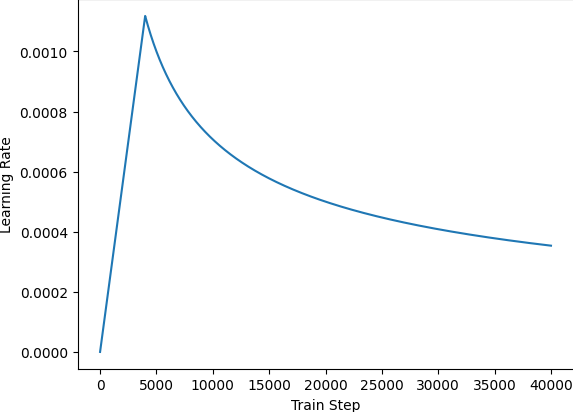

In [219]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
    
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
    
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
    
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(d_model)

plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [220]:
transformer.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=optimizer,
    metrics=["accuracy"])

In [221]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_weights_checkpoint.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=2
)

In [222]:
%%time
transformer.fit(train_ds,
                validation_data=valid_ds,
                epochs=20,
                callbacks=[checkpoint_callback],
                verbose = 2)

Epoch 1/20

Epoch 1: val_loss improved from inf to 9.17484, saving model to model_weights_checkpoint.h5
1028/1028 - 1020s - loss: 11.1382 - accuracy: 0.0040 - val_loss: 9.1748 - val_accuracy: 0.0042 - 1020s/epoch - 992ms/step
Epoch 2/20


KeyboardInterrupt: 

In [151]:
# Manual inference on test input
test_inp = np.zeros((1, FRAME_LEN, lm_shape))
logits = transformer(test_inp)
pred_idx = np.argmax(tf.nn.softmax(logits)[0][0])
idx_to_sign[pred_idx]

','

# Save model

In [85]:
tf_signs = tf.constant(list(sign_to_num.keys()), dtype=tf.string)
tf_nums = tf.constant(list(sign_to_num.values()), dtype=tf.int64)

class SignTranslatingTransformer(tf.Module):
    def __init__(self, model: Transformer):
        super(SignTranslatingTransformer, self).__init__()
        self.model = model
        
        self.tf_num_to_sign = tf.lookup.StaticHashTable(
            initializer=tf.lookup.KeyValueTensorInitializer(
                keys=tf_signs,
                values=tf_nums,
            ),
            default_value=tf.constant(-1, dtype=tf.int64),
            name="tf_sign_to_num_lut"
        )

    @tf.function(input_signature=[
        tf.TensorSpec(shape=[tf.constant(FRAME_LEN), tf.constant(lm_shape)], dtype=tf.float32),
    ])
    def predict(self, landmarks):
        # Preprocess
        batched_landmarks = tf.expand_dims(landmarks, axis=0)
        
        # Inference
        logits = self.model(batched_landmarks, training=False)[0]
        
        # Parse result
        probabilities = tf.nn.softmax(logits)
        pred_prob = tf.reduce_max(probabilities)
        pred_idx = tf.argmax(probabilities)
        pred_sign = self.tf_num_to_sign.lookup(pred_idx)
        
        return {'result' : pred_sign, 'confidence': pred_prob}

In [86]:
transformer_wrapper = SignTranslatingTransformer(transformer)

In [88]:
%%time
transformer_wrapper.predict(np.zeros((FRAME_LEN, lm_shape)))

CPU times: total: 78.1 ms
Wall time: 30 ms


{'result': <tf.Tensor: shape=(), dtype=string, numpy=b'_'>,
 'confidence': <tf.Tensor: shape=(), dtype=float32, numpy=0.14182165>}

In [200]:
save_model_name = "saved_model"
if os.path.isdir(save_model_name):
    print(f"A model with the same name has already been saved!")
else:
    tf.saved_model.save(transformer_wrapper, export_dir=save_model_name)

INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


# Load model

## From saved weights

1. Create model object with same parameters
2. Build the model (run inference on it, to initialize the parameters)
3. Load the weights
4. Convert it to tf.Module or run manual inference on it

In [91]:
d_model = 200 # embedding size

transformer = Transformer(
    len_lm_seq=FRAME_LEN,
    num_enc_layers=2,
    num_conv_layers=3,
    filter_size=11,
    d_model=d_model,
    num_heads=4,
    dff=200, 
    num_signs=len(sign_to_num),
    dropout_rate=0.1)

In [92]:
# Example inference to build the model
lm_seq, sing_idx = next(iter(train_ds))
output = transformer(lm_seq)

print("Input shpae: " + lm_seq.shape)
print("Output shape: " + output.shape)

transformer.summary()

(32, 256, 78)
(32, 32)
(32, 32, 62)
Model: "transformer_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_4 (Encoder)         multiple                  4031232   
                                                                 
 decoder_4 (Decoder)         multiple                  2252800   
                                                                 
 dense_34 (Dense)            multiple                  15934     
                                                                 
Total params: 6299966 (24.03 MB)
Trainable params: 6299966 (24.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [93]:
new_model.get_weights()

[array([[[ 0.00747312,  0.03405446,  0.01337567, ..., -0.01857238,
          -0.00065049, -0.02861774],
         [ 0.00411984, -0.00161408,  0.01754182, ...,  0.0019397 ,
          -0.02788948,  0.01101368],
         [ 0.02296002, -0.03760214,  0.00705639, ..., -0.03536383,
          -0.0107779 ,  0.0216161 ],
         ...,
         [ 0.0325331 , -0.02539058, -0.02124684, ...,  0.0164182 ,
          -0.00853428, -0.00264945],
         [ 0.00553249,  0.00772436, -0.03149552, ..., -0.00221829,
          -0.00089342, -0.02846104],
         [ 0.01756696,  0.03821947,  0.00670712, ..., -0.01568516,
           0.03459681, -0.00653311]],
 
        [[ 0.02300119,  0.01874669,  0.02883168, ...,  0.02455828,
          -0.00716674, -0.02810469],
         [-0.03669284,  0.00082913, -0.02247901, ...,  0.01335107,
           0.00185111,  0.01796568],
         [-0.00478459,  0.01959257,  0.01187844, ..., -0.00894401,
           0.01624188,  0.00805777],
         ...,
         [ 0.01614928,  0.0257571

In [94]:
new_model.load_weights("model_weights_checkpoint.h5")

In [95]:
new_model.get_weights()

[array([[[-3.49358171e-02,  9.90823377e-03,  1.52775288e-01, ...,
          -5.73357902e-02, -1.80295750e-03,  7.84387365e-02],
         [ 1.35337058e-02, -4.39356491e-02, -2.62387004e-02, ...,
           7.55227730e-03, -2.45078839e-02, -5.84629038e-03],
         [ 9.47885513e-02,  5.28908782e-02, -1.24472082e-02, ...,
           5.73811308e-02, -3.59199122e-02, -5.23235761e-02],
         ...,
         [ 9.81561020e-02, -5.74827902e-02, -3.33295241e-02, ...,
          -8.97862837e-02, -1.20846495e-01, -7.35713402e-03],
         [ 6.37987852e-02,  9.71613172e-03, -6.90640062e-02, ...,
          -5.13906442e-02, -1.40112778e-02, -6.66867197e-02],
         [-5.29663078e-03,  2.85592675e-02,  4.35808022e-03, ...,
           5.97897954e-02, -3.74283157e-02,  3.72958742e-02]],
 
        [[-3.03895008e-02, -6.53635859e-02,  1.21020824e-01, ...,
          -1.29117426e-02,  5.55875786e-02,  3.28719839e-02],
         [-8.23512748e-02,  3.30609567e-02,  4.81356047e-02, ...,
          -3.23076099

In [96]:
# Manual inference on test input
test_inp = np.zeros((1, FRAME_LEN, lm_shape))
logits = transformer(test_inp)
pred_idx = np.argmax(tf.nn.softmax(logits)[0][0])
idx_to_sign[pred_idx]

'm'

In [97]:
loaded_model = SignTranslatingTransformer(new_model)

In [98]:
loaded_model.predict(np.zeros((FRAME_LEN, lm_shape)))

{'result': <tf.Tensor: shape=(), dtype=string, numpy=b'm'>,
 'confidence': <tf.Tensor: shape=(), dtype=float32, numpy=0.09073451>}

## From saved model

In [102]:
loaded_model = tf.saved_model.load("test_model")

In [103]:
loaded_model.predict(np.zeros((FRAME_LEN, lm_shape)))

{'result': <tf.Tensor: shape=(), dtype=string, numpy=b'8'>,
 'confidence': <tf.Tensor: shape=(), dtype=float32, numpy=0.112675235>}

# Testing

## On Test dataset

In [107]:
def generate(fs_model, inp, max_len):
    ctx = str(num_to_char[start_token_idx])
    for i in range(max_len):
        res = fs_model.predict(inp, ctx)
        res_char = res["result"].numpy().decode("utf-8")
        ctx += res_char

        if res_char == num_to_char[end_token_idx]:
            break
    return ctx

def generate_teacher_forcing(fs_model, inp, expected):
    pred = str(num_to_char[start_token_idx])
    ctx = str(num_to_char[start_token_idx])
    for e in expected:
        if e == 'P':
            break
        res = fs_model.predict(inp, ctx)
        res_char = res["result"].numpy().decode("utf-8")
        pred += res_char
        ctx += e
    return pred

In [108]:
(inp_batch, _ctx), expected_batch = random.choice([batch for batch in valid_ds])
for seq, expected in zip(inp_batch, expected_batch):
    expected = "".join([num_to_char[num.numpy()] for num in expected])

    print("Expected: " + expected)
    print("Gen on own: " + generate(loaded_model, seq, MAX_PHRASE_LEN))
    print("Gen teacher forcing: " + generate_teacher_forcing(loaded_model, seq, expected))
    print('\n~~~\n')

Expected: golfcourseweddings>PPPPPPPPPPPPP
Gen on own: <+61-05-206-18>
Gen teacher forcing: <+obf-rtro wodey>g..

~~~

Expected: 9396 yuchi lane>PPPPPPPPPPPPPPPP
Gen on own: <93396 yuchi lane>
Gen teacher forcing: <9336 yuchi lane>

~~~

Expected: 506-993-4525>PPPPPPPPPPPPPPPPPPP
Gen on own: <506-993-4525>
Gen teacher forcing: <506-993-4525>

~~~

Expected: 428823 winter house>PPPPPPPPPPPP
Gen on own: <428823 winter horse>
Gen teacher forcing: <428823 winter horse>

~~~

Expected: america_2>PPPPPPPPPPPPPPPPPPPPPP
Gen on own: <anmrica.12>
Gen teacher forcing: <anrrica.1>

~~~

Expected: 628-137-7392>PPPPPPPPPPPPPPPPPPP
Gen on own: <628-137-7392>
Gen teacher forcing: <628-137-7392>

~~~

Expected: 370 ivy spring>PPPPPPPPPPPPPPPPP
Gen on own: <370 vys pring>
Gen teacher forcing: <370 vvy spring>

~~~

Expected: 889-022-9065>PPPPPPPPPPPPPPPPPPP
Gen on own: <889-022-9065>
Gen teacher forcing: <889-022-9065>

~~~

Expected: ronnie simon>PPPPPPPPPPPPPPPPPPP
Gen on own: <randie orraie>
Gen tea

## Real life testing

### Util for handling video feed

In [165]:
mp_pose = mp.solutions.pose
mp_hands = mp.solutions.hands
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles

def draw_landmarks_on_image(image, results):
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    mp_drawing.draw_landmarks(
        image,
        results.face_landmarks,
        mp_holistic.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp_drawing_styles
        .get_default_face_mesh_contours_style())
    mp_drawing.draw_landmarks(
        image,
        results.pose_landmarks,
        mp_holistic.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles
        .get_default_pose_landmarks_style())
    mp_drawing.draw_landmarks(
        image,
        results.left_hand_landmarks,
        mp_holistic.HAND_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style()
    )
    mp_drawing.draw_landmarks(
        image,
        results.right_hand_landmarks,
        mp_holistic.HAND_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style()
    )
    return image

In [166]:
def extract_from_result(res):
    # Extract specific pose landmarks if available
    px = []
    py = []
    pz = []
    if res.pose_landmarks:
        for i in POSE:
            lm = res.pose_landmarks.landmark[i]
            px.append(lm.x)
            py.append(lm.y)
            pz.append(lm.z)
    else:
        px = [0.0]*len(POSE)
        py = [0.0]*len(POSE)
        pz = [0.0]*len(POSE)

    # Extract left hand landmarks if available
    lx = []
    ly = []
    lz = []
    if res.left_hand_landmarks:
        for lm in res.left_hand_landmarks.landmark:
            lx.append(lm.x)
            ly.append(lm.y)
            lz.append(lm.z)
    else:
        lx = [0.0]*21
        ly = [0.0]*21
        lz = [0.0]*21

    # Extract right hand landmarks if available
    rx = []
    ry = []
    rz = []
    if res.right_hand_landmarks:
        for lm in res.right_hand_landmarks.landmark:
            rx.append(lm.x)
            ry.append(lm.y)
            rz.append(lm.z)
    else:
        rx = [0.0]*21
        ry = [0.0]*21
        rz = [0.0]*21

    return list(chain(rx, lx, px, ry, ly, py, rz, lz, pz))

In [167]:
def video_loop(source, process_data_func):
    video = cv2.VideoCapture(source)
    display_handle=display(None, display_id=True)
    try:
        with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
            while True:
                _, frame = video.read()
    
                if frame is None:
                    break
    
                #image = cv2.resize(frame, (360, 240))
                image=frame
    
                # To improve performance, optionally mark the image as not writeable to pass by reference.
                image.flags.writeable = False
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                results = holistic.process(image)
                data = extract_from_result(results)

                process_data_func(data)
    
                # Draw landmark annotation on the image.
                image = draw_landmarks_on_image(image, results)
    
                image = cv2.flip(image, 1)
                _, image = cv2.imencode('.jpeg', image)
                display_handle.update(Image(data=image.tobytes()))
    except KeyboardInterrupt:
        pass
    finally:
        video.release()
        display_handle.update(None)

### Util for handling models

#### Signing detector

In [272]:
# Only load once
signing_detection_model = tf.saved_model.load("signing_detection_model")

class SigningDetectionModel:
    def __init__(self):
        self.signing_detection_model_input = list(np.zeros((15, 156)))

    def is_signing(self, inp_lm):
        self.signing_detection_model_input.pop(0)
        self.signing_detection_model_input.append(inp_lm)
        return signing_detection_model.predict(self.signing_detection_model_input)["result"].numpy() == 1

class BufferedSigningDetectionModel:
    def __init__(self, buffer_len=5, confidence_number=3):
        self.signing_detection_model_input = list(np.zeros((15, 156)))
        self.signing_detector_buffer = deque(maxlen=buffer_len)
        self.confidence_number = confidence_number 

    def is_signing(self, inp_lm):
        self.signing_detection_model_input.pop(0)
        self.signing_detection_model_input.append(inp_lm)
        pred = signing_detection_model.predict(self.signing_detection_model_input)["result"].numpy()
        self.signing_detector_buffer.append(pred)
        buffered_pred, count = Counter(self.signing_detector_buffer).most_common(1)[0]
        if count >= self.confidence_number:
            return buffered_pred == 1
        else:
            return False

#### Fingerspelling recognition models

In [300]:
# Only load once
loaded_transformer_model = loaded_model

class ContinuousRecognitionModel:
    def __init__(self, confidence_threshold=0.2, inp_buf_len=30, out_buf_len=10, out_majority_threshold=7):
        self.input = []
        self.trust_confidence = confidence_threshold
        self.inp_len = inp_buf_len
        self.inner_fifo = deque(maxlen=out_buf_len)
        self.confidence_number = out_majority_threshold
        self.context = str(num_to_char[start_token_idx])

    def process_frame(self, frame):
        if len(self.input) >= self.inp_len:
            self.input.pop(0)
        self.input.append(frame)
    
        inp = pre_process(self.input)
        res = loaded_transformer_model.predict(inp, self.context)
        pred = res["result"].numpy().decode("utf-8")
        prob = res["confidence"].numpy()

        if prob < self.trust_confidence:
            return

        self.inner_fifo.append(pred)
        pred_char, count = Counter(self.inner_fifo).most_common(1)[0]
        if count >= self.confidence_number:
            if self.context[-1] != pred_char:
                self.context += pred_char
                print(pred_char, end="")
                
                # Predicted the end
                if pred_char == '>':
                    # restart the detection
                    self.context = str(num_to_char[start_token_idx])
                    self.inner_fifo.clear()
                    self.input.clear()

class NonContinuousRecognitionModel:
    def __init__(self, max_out_length=MAX_PHRASE_LEN, max_input_length=FRAME_LEN, confidence_threshold=0.2):
        self.max_out_length = max_out_length
        self.max_input_length = max_input_length
        self.confidence_threshold = confidence_threshold
        self.input = []

    def reset_buffer(self):
        self.input.clear()

    def translate_buffered_content(self, reset_buffer=False):
        if len(self.input) > 0:
            inp = pre_process(self.input)
            print(self._generate_with_confidence(inp))
        if reset_buffer:
            self.reset_buffer()

    def process_frame(self, inp_lm):
        self.input.append(inp_lm)
        
        if len(self.input) >= FRAME_LEN:
            self.translate_buffered_content()
            self.reset_buffer()

    def _generate_with_confidence(self, inp):
        ctx = str(num_to_char[start_token_idx])
        for i in range(self.max_out_length):
            res = loaded_model.predict(inp, ctx)
            res_char = res["result"].numpy().decode("utf-8")
            prob = res["confidence"].numpy()
            if prob > self.confidence_threshold:
                ctx += res_char
                if res_char == num_to_char[end_token_idx]:
                    break
        return ctx

### Running diffrent configurations

#### Continuous model without signing detection

Works well for isolated sequences. Can't handle sudden pauses, and stops.
Extremely sensitive to window size. Also, the training data was from professional signers. For beginners who sign slower the same window size isn't suitable.

In [302]:
fs_model = ContinuousRecognitionModel(confidence_threshold=0.2, inp_buf_len=30, out_buf_len=10, out_majority_threshold=7)
video_loop("test_videos/bear.mp4", lambda data: fs_model.process_frame(data))

None

beark

#### Continuous model with signing detection

Handles breaks at the start and end, but doesn't account for breaks mid-signing, or multiple words, as the model's buffer is only filled when signing is detected. This can lead to jumps in the buffer data.

In [303]:
sign_detector = SigningDetectionModel()
#sign_detector = BufferedSigningDetectionModel()
fs_model = ContinuousRecognitionModel(confidence_threshold=0.2, inp_buf_len=30, out_buf_len=10, out_majority_threshold=7)

def process_data(data):
    if sign_detector.is_signing(data):
        print("*", end="")
        fs_model.process_frame(data)
    else:
        print("-", end="")

video_loop("test_videos/alligator.mp4", process_data)

None

--------------*******************************--------*********a*******l*******************************i*******g*******a*******t*******o*******r*******>--------------*****

In [ ]:
# TODO model that takes input frames all the time but only predicts when signing is detected!!!!!
# Continue the train of thought for the rest!!!

#### Translate in long chunks

This model performs well on single words that fit into the buffer. But for longer text it fails to translate well, presumable because the signs are cut off at the wrong positions. For longer text pause detection/signing detection is needed.

In [310]:
fs_model = NonContinuousRecognitionModel(max_out_length=MAX_PHRASE_LEN, max_input_length=FRAME_LEN, confidence_threshold=0.2)
video_loop("test_videos/bear.mp4", lambda data: fs_model.process_frame(data))
fs_model.translate_buffered_content()

None

<beark>


#### Translate in long chunks  with signing detection

In [307]:
fs_model = NonContinuousRecognitionModel(max_out_length=MAX_PHRASE_LEN, max_input_length=FRAME_LEN, confidence_threshold=0.2)
sign_detector = SigningDetectionModel()
#sign_detector = BufferedSigningDetectionModel()

def process_data(data):
    if sign_detector.is_signing(data):
        fs_model.process_frame(data)

video_loop("test_videos/monkey.mp4", process_data)
fs_model.translate_buffered_content()

None

<monkey >


#### Translate longer sequences with stops

In [308]:
fs_model = NonContinuousRecognitionModel(max_out_length=MAX_PHRASE_LEN, max_input_length=FRAME_LEN, confidence_threshold=0.2)
sign_detector = SigningDetectionModel()
#sign_detector = BufferedSigningDetectionModel()

def process_data(data):
    if sign_detector.is_signing(data):
        fs_model.process_frame(data)
    else:
        fs_model.translate_buffered_content(reset_buffer=True)

video_loop("test_videos/fingerspelling_animals.mp4", process_data)
fs_model.translate_buffered_content()

None

<earkn>
<
<tigerr>
<
<ebraa>
<
<yena>
<
<angaroo hangaroo>
<monkey >
<
<lyonn parks>
<s
<alligator>
<horse horse>
<


# LLM to improve the quality of the response

In [225]:
%%capture
!pip install openai

In [226]:
import openai

In [233]:
key = os.environ.get('OPEN_AI_API_KEY')
if key is not None:
    openai.api_key = key
else:
    print("Error: Please set a valid api key!")

Error: Please set a valid api key!


In [242]:
def correct_output(pred):
    completion = openai.ChatCompletion.create(
      model="gpt-3.5-turbo", 
       messages=[
        {"role": "system", "content": "You are a machine that tries to correct the output of a fingerspelling recognition model. Some letters might be missing, but it's also possible that the given text has extra characters. Only reply the corrected text."},
        {"role": "user", "content": "angaro angaro"},
        {"role": "system", "content": "kangaroo"},
        {"role": "user", "content": "beark"},
        {"role": "system", "content": "bear"},
        {"role": "user", "content": "6 halee hale"},
        {"role": "system", "content": "whale"},
        {"role": "user", "content": pred},
      ]
    )
    
    return completion["choices"][0]["message"]["content"]

In [251]:
correct_output("earkh/tiger/tiger angar key ligator alligator h horse gro")

'earth/tiger/angary ligator alligator horse gro'